<a href="https://colab.research.google.com/github/DarkSchneider/Exercises/blob/main/lab5_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercizio 1
* Caricare l'immagine ${\tt camera()}$ dal modulo ${\tt skimage.data}$, rinormalizzandola nel range $[0,1]$.
* Applicare un blur di tipo gaussiano con deviazione standard $3$ il cui kernel ha dimensioni $24\times 24$ utilizzando le funzioni fornite: ${\tt gaussian\_kernel()}$, ${\tt psf\_fft()}$ ed ${\tt A()}$.
* Aggiungere rumore di tipo gaussiano, con deviazione standard $0.02$, usando la funzione ${\tt np.random.normal()}$.
* Calcolare il Peak Signal Noise Ratio (**PSNR**) ed il Mean Squared Error (**MSE**) tra l'immagine degradata e l'immagine originale usando le funzioni ${\tt peak\_signal\_noise\_ratio}$ e ${\tt mean\_squared\_error}$ disponibili nel modulo ${\tt skimage.metrics}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft

In [3]:
help(metrics.peak_signal_noise_ratio)

Help on function peak_signal_noise_ratio in module skimage.metrics.simple_metrics:

peak_signal_noise_ratio(image_true, image_test, *, data_range=None)
    Compute the peak signal to noise ratio (PSNR) for an image.
    
    Parameters
    ----------
    image_true : ndarray
        Ground-truth image, same shape as im_test.
    image_test : ndarray
        Test image.
    data_range : int, optional
        The data range of the input image (distance between minimum and
        maximum possible values).  By default, this is estimated from the image
        data-type.
    
    Returns
    -------
    psnr : float
        The PSNR metric.
    
    Notes
    -----
    .. versionchanged:: 0.16
        This function was renamed from ``skimage.measure.compare_psnr`` to
        ``skimage.metrics.peak_signal_noise_ratio``.
    
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio



In [4]:
# Crea un kernel Gaussiano di dimensione kernlen e deviazione standard sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Kernel gaussiano unidmensionale
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Kernel gaussiano bidimensionale
    kern2d = np.outer(kern1d, kern1d)
    # Normalizzazione
    return kern2d / kern2d.sum()

# Esegui l'fft del kernel K di dimensione d aggiungendo gli zeri necessari 
# ad arrivare a dimensione shape
def psf_fft(kern2d, d, shape):
    # Aggiungi zeri
    K_p = np.zeros(shape)
    K_p[:d, :d] = kern2d

    # Sposta elementi
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Esegui FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

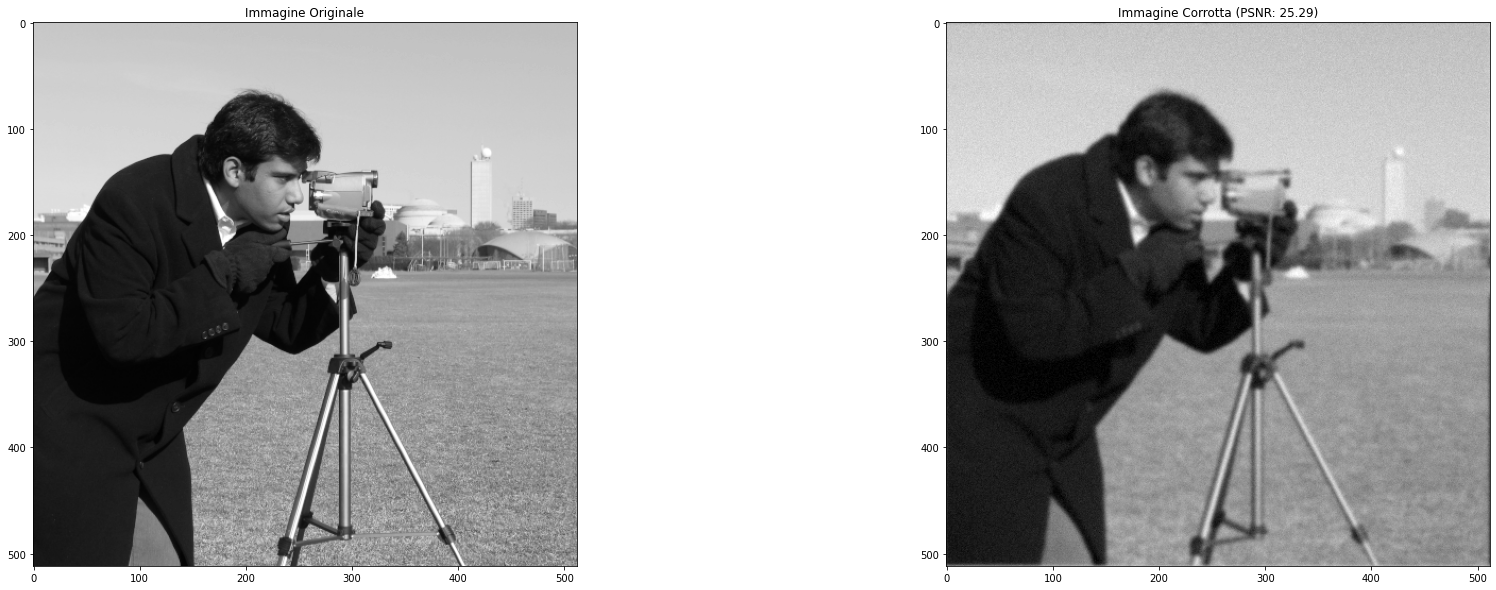

In [5]:
# Immagine in floating point con valori tra 0 e 1
X = data.camera().astype(np.float64) / 255.0
m, n = X.shape

# Genera il filtro di blur
K = psf_fft(gaussian_kernel(24,3),24,X.shape)
# Genera il rumore
sigma = 0.02
noise = np.random.normal(size=X.shape)*sigma

# Aggiungi blur e rumore
b = A(X,K) + noise
MSE = metrics.mean_squared_error(X,b)
PSNR = metrics.peak_signal_noise_ratio(X,b)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Originale')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(b, cmap='gray', vmin=0, vmax=1)
plt.title(f'Immagine Corrotta (PSNR: {PSNR:.2f})')

plt.show()

In [6]:
PSNR = metrics.peak_signal_noise_ratio(X,b)
MSE = metrics.mean_squared_error(X,b)
print('This is the MSE: ', MSE)
print('This is the PSNR: ', PSNR)

This is the MSE:  0.0029554860182002688
This is the PSNR:  25.293710908685817


# **Esercizio 2**: Function ${\tt minimize}$
---
* Importare la function ${\tt minimize}$ da ${\tt scipy.optimize}$ e visualizzarne l'help.
* Usando la function ${\tt minimize}$ con il metodo ${\tt 'CG'}$ minimizzare la funzione $f:\mathbb{R}^n\rightarrow\mathbb{R}$ definita come: $$f(x)=\sum_i^n(x_i-1)^2$$ 
* Analizzare la struttura restituita in output dalla function ${\tt minimize}$.

In [21]:
from scipy.optimize import minimize

help(minimize)
#minimize(f, x0, method='CG', jac=df)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [18]:
def f(X):
  res = (X - 1)**2
  return np.sum(res)

def df(X):
  res = 2*(X-1)
  return res 

In [22]:
x0 = np.array([2, -10])
res = minimize(f, x0, method='CG', jac=df)

In [23]:
print(res)

     fun: 3.2047474274603605e-30
     jac: array([ 4.44089210e-16, -3.55271368e-15])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 1
    njev: 4
  status: 0
 success: True
       x: array([1., 1.])


In [24]:
type(res)

scipy.optimize.optimize.OptimizeResult

In [25]:
res.x

array([1., 1.])